#Görev Tanımı
Bu görevde, verilen ahşap yüzey verileri kullanılarak denetimsiz öğrenme (unsupervised learning) yaklaşımıyla bir anomali tespit modeli geliştirilecektir. Model, ahşap yüzeyinde kusurların veya düzensizliklerin tespit edilmesi için eğitilecektir.


#1. Ön İşleme Adımları ve Veri Hazırlığı


In [1]:
import cv2
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import os

# Google Drive'ı bağla
drive.mount('/content/drive', force_remount=True)


# Drive'dan veri setine erişim
data_path = '/content/drive/MyDrive/wood_dataset'

# İşlenmiş resimler için çıkış ana klasörü
processed_data_path = '/content/drive/MyDrive/processed_dataset'

# Gerekli dizinleri oluştur (train, test, ground_truth)
subdirs = ['train/good', 'test/good', 'test/defect', 'ground_truth/defect']
for subdir in subdirs:
    full_path = os.path.join(processed_data_path, 'wood', subdir)
    os.makedirs(full_path, exist_ok=True)

print("Tüm dizinler oluşturuldu ve hazır.")

Mounted at /content/drive
Tüm dizinler oluşturuldu ve hazır.


###Arka Planı Kaldırma


In [ ]:
def crop_and_clean(image):
    # Gri tonlamaya çevir
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Otsu Threshold uygula
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Siyah olmayan alanları bul
    coords = cv2.findNonZero(thresh)

    if coords is not None:
        # En küçük dikdörtgeni belirle ve kırp
        x, y, w, h = cv2.boundingRect(coords)
        cropped_image = image[y:y+h, x:x+w]

        # İkinci kontrol
        gray_cropped = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
        _, clean_thresh = cv2.threshold(gray_cropped, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Yeniden kırp
        new_coords = cv2.findNonZero(clean_thresh)
        if new_coords is not None:
            x2, y2, w2, h2 = cv2.boundingRect(new_coords)
            cropped_image = cropped_image[y2:y2+h2, x2:x2+w2]

    return cropped_image


###Görüntü Normalizasyonu ve Boyutlandırma

In [ ]:
def resize_and_normalize(image, target_size=(256, 256)):
    # Boyutlandırma
    resized_image = cv2.resize(image, target_size)

    # Normalizasyon [0, 1] aralığına
    normalized_image = resized_image / 255.0

    return normalized_image


In [ ]:
def enhance_contrast_clahe(image):
    # Gri tonlamaya çevir
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # CLAHE oluştur
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    # CLAHE uygula
    equalized = clahe.apply(gray)

    # Tekrar 3 kanallıya çevir
    equalized_color = cv2.cvtColor(equalized, cv2.COLOR_GRAY2BGR)

    return equalized_color


In [ ]:
def process_image(image):
    # Kırpma ve temizleme
    cropped_image = crop_and_clean(image)

    # Kontrast artırma
    # enhanced_image = enhance_contrast_clahe(cropped_image) sonra tekrar denenir

    # Boyutlandırma ve normalizasyon
    final_image = resize_and_normalize(cropped_image)


    return final_image


In [ ]:
# İşlenecek alt klasörler
subdirs_to_process = ['train/good', 'test/good', 'test/defect']

for subdir in subdirs_to_process:
    input_dir = os.path.join(data_path, 'wood', subdir)
    output_dir = os.path.join(processed_data_path, 'wood', subdir)
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        if filename.lower().endswith(('jpg', 'png')):
            img_path = os.path.join(input_dir, filename)
            image = cv2.imread(img_path)

            if image is None:
                print(f"Atlandı: {filename} okunamadı.")
                continue

            processed_image = process_image(image)
            processed_image = (processed_image * 255).astype(np.uint8)

            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR))

            print(f"{subdir}/{filename} işlendi ve kaydedildi.")

print("Tüm klasörlerdeki resimler işlendi ve processed_dataset klasörüne kaydedildi.")

train/good/10.jpg işlendi ve kaydedildi.
train/good/8.jpg işlendi ve kaydedildi.
train/good/12.jpg işlendi ve kaydedildi.
train/good/4.jpg işlendi ve kaydedildi.
train/good/11.jpg işlendi ve kaydedildi.
train/good/7.jpg işlendi ve kaydedildi.
train/good/5.jpg işlendi ve kaydedildi.
train/good/9.jpg işlendi ve kaydedildi.
train/good/6.jpg işlendi ve kaydedildi.
train/good/23.jpg işlendi ve kaydedildi.
train/good/19.jpg işlendi ve kaydedildi.
train/good/21.jpg işlendi ve kaydedildi.
train/good/30.jpg işlendi ve kaydedildi.
train/good/34.jpg işlendi ve kaydedildi.
train/good/15.jpg işlendi ve kaydedildi.
train/good/31.jpg işlendi ve kaydedildi.
train/good/28.jpg işlendi ve kaydedildi.
train/good/20.jpg işlendi ve kaydedildi.
train/good/33.jpg işlendi ve kaydedildi.
train/good/22.jpg işlendi ve kaydedildi.
train/good/27.jpg işlendi ve kaydedildi.
train/good/24.jpg işlendi ve kaydedildi.
train/good/13.jpg işlendi ve kaydedildi.
train/good/26.jpg işlendi ve kaydedildi.
train/good/32.jpg işle

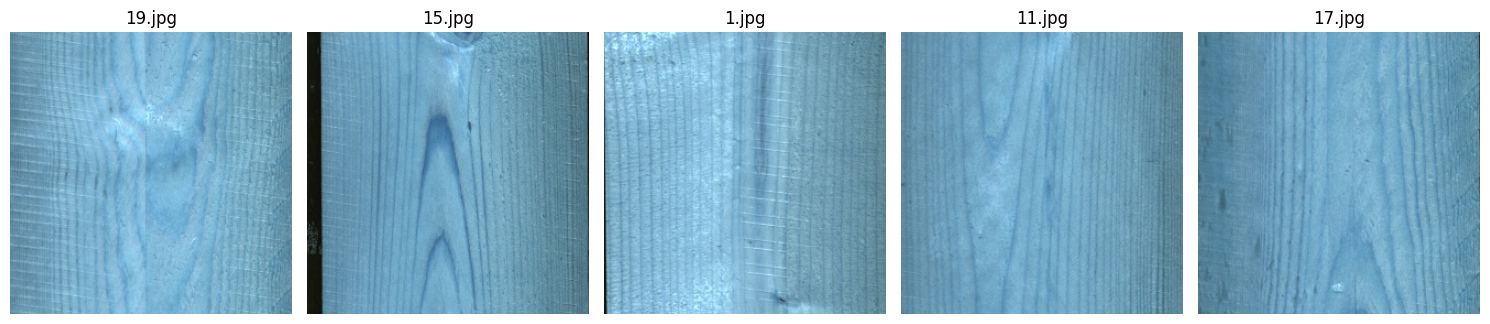

In [ ]:
import matplotlib.pyplot as plt
import os
import cv2

# İşlenmiş train klasörü yolu
train_dir = os.path.join(processed_data_path, 'wood', 'train', 'good')

# İlk 5 işlenmiş görüntüyü al
sample_images = os.listdir(train_dir)[:5]
fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))

for idx, filename in enumerate(sample_images):
    img_path = os.path.join(train_dir, filename)
    processed_image = cv2.imread(img_path)
    processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)

    axes[idx].imshow(processed_image)
    axes[idx].axis("off")
    axes[idx].set_title(f"{filename}")

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import os

# Ground truth klasör yolları
src_gt = os.path.join(data_path, 'wood', 'ground_truth', 'defect')
dst_gt = os.path.join(processed_data_path, 'wood', 'ground_truth', 'defect')

# Çıkış klasörü varsa yok say, yoksa oluştur
os.makedirs(dst_gt, exist_ok=True)

# Maskeleri işle
for filename in os.listdir(src_gt):
    if filename.lower().endswith(('.png', '.jpg')):
        src_path = os.path.join(src_gt, filename)
        dst_path = os.path.join(dst_gt, filename)

        # Maskeyi gri tonlamada oku
        mask = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)

        # Yeniden boyutlandır (normalize etmeden!)
        resized_mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        # Kaydet
        cv2.imwrite(dst_path, resized_mask)

print("Ground truth maskeleri 256x256 boyutuna getirilerek kaydedildi.")



Ground truth maskeleri 256x256 boyutuna getirilerek kaydedildi.


#2. Denetimsiz Model Eğitimi

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import cv2
import os

##2.1 FastFlow


In [3]:
!pip install anomalib[full]

In [40]:
from anomalib.data import Folder
from anomalib.models import Fastflow
from anomalib.engine import Engine
from pytorch_lightning.loggers import CSVLogger
from anomalib.visualization import ImageVisualizer

visualizer = ImageVisualizer

datamodule = Folder(
    name = "wood_dataset",
    root = "/content/drive/MyDrive/processed_dataset/wood",
    normal_dir="train/good",
    normal_test_dir="test/good",
    mask_dir="ground_truth/defect",
    abnormal_dir="test/defect",
    test_split_mode= "from_dir",

    train_batch_size=8,
    eval_batch_size=8,
    num_workers=2,
)

model = Fastflow(
    backbone = "wide_resnet50_2",
    pre_trained = True,
    flow_steps=8,
    visualizer= True
)

logger = CSVLogger(save_dir="/content/drive/MyDrive", name = "fastflow_logs")
engine = Engine(max_epochs = 30, logger = logger)

engine.fit(model, datamodule=datamodule)
predictions = engine.predict(model, datamodule=datamodule)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | pre_processor  | PreProcessor  | 0      | train
1 | post_processor | PostProcessor | 0      | train
2 | evaluator      | Evaluator     | 0      | train
3 | model          | FastflowModel | 91.9 M | train
4 | loss           | FastflowLoss  | 0      | train
---------------------------------------------------------
45.0 M    Trainable params
46.9 M    Non-trainable params
91.9 M    Total params
367.562   Total estimated model params size (MB)
372       Modules in train mode
0         Modules in eval m

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [41]:
test_results = engine.test(model, datamodule=datamodule)
print("Test Sonuçları:", test_results)

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9023809432983398     │
│       image_F1Score       │    0.8461538553237915     │
│        pixel_AUROC        │    0.9347207546234131     │
│       pixel_F1Score       │    0.28576385974884033    │
└───────────────────────────┴───────────────────────────┘

Test Sonuçları: [{'image_AUROC': 0.9023809432983398, 'image_F1Score': 0.8461538553237915, 'pixel_AUROC': 0.9347207546234131, 'pixel_F1Score': 0.28576385974884033}]


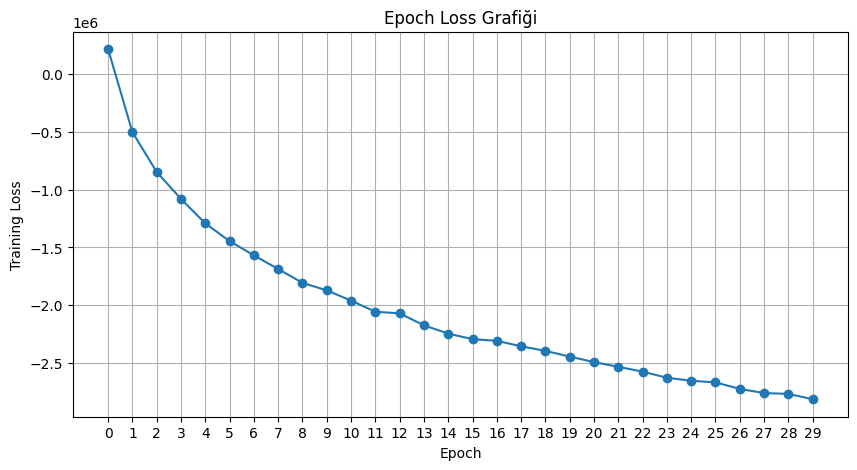

In [42]:
# Loss Grafiği Oluşturma
import pandas as pd
log_dir = logger.log_dir
metrics_path = os.path.join(log_dir, 'metrics.csv')

if os.path.exists(metrics_path):
    try:
        metrics = pd.read_csv(metrics_path)

        loss_col_to_plot = 'train_loss_epoch'
        epoch_col = 'epoch'

        if epoch_col in metrics.columns and loss_col_to_plot in metrics.columns:
            plot_data = metrics.dropna(subset=[epoch_col, loss_col_to_plot]).copy() # Copy() dataframe slice uyarısını engeller

            if not plot_data.empty:
                plot_data[epoch_col] = pd.to_numeric(plot_data[epoch_col], errors='coerce')
                plot_data[loss_col_to_plot] = pd.to_numeric(plot_data[loss_col_to_plot], errors='coerce')

                plot_data = plot_data.dropna(subset=[epoch_col, loss_col_to_plot])

                plot_data = plot_data.sort_values(by=epoch_col)

                if not plot_data.empty:
                    plt.figure(figsize=(10, 5))
                    plt.plot(plot_data[epoch_col], plot_data[loss_col_to_plot], marker='o', linestyle='-')
                    plt.title('Epoch Loss Grafiği')
                    plt.xlabel('Epoch')
                    plt.ylabel('Training Loss')
                    plt.grid(True)

                    plt.xticks(plot_data[epoch_col].unique().astype(int))
                    plt.show()
                else:
                     print(f"Uyarı: Sayısal değere dönüştürüldükten veya filtrelendikten sonra '{loss_col_to_plot}' sütununda grafiklemek için yeterli veri bulunamadı.")

            else:
                print(f"Uyarı: '{loss_col_to_plot}' sütununda NaN olmayan veri içeren satır bulunamadı. metrics.csv dosyasını kontrol edin.")

        else:
            print(f"Hata: CSV dosyasında '{epoch_col}' veya '{loss_col_to_plot}' sütunu bulunamadı. Sütun adlarını kontrol edin.")

    except Exception as e:
        print(f"metrics.csv okunurken veya işlenirken hata oluştu: {e}")
        print(f"Metrik dosyası yolu: {metrics_path}")


INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


F1AdaptiveThreshold ile Hesaplanan Optimal Piksel Eşiği: 0.5059

İlk 5 Resim İçin Maske Karşılaştırması ve IoU Dğerleri (Hesaplanan Eşik: 0.5059 İle):
Resim 1 (100000003.jpg): IoU = 0.0000


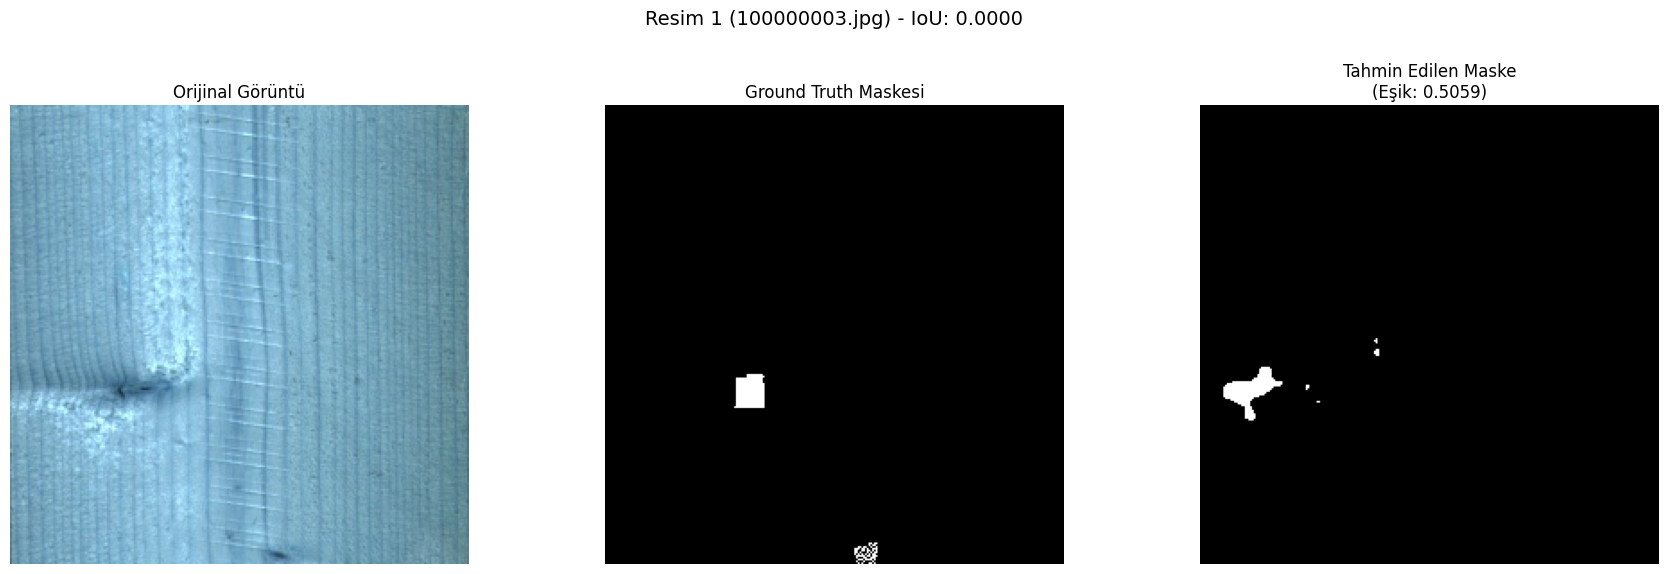

Resim 2 (100000006.jpg): IoU = 0.1463


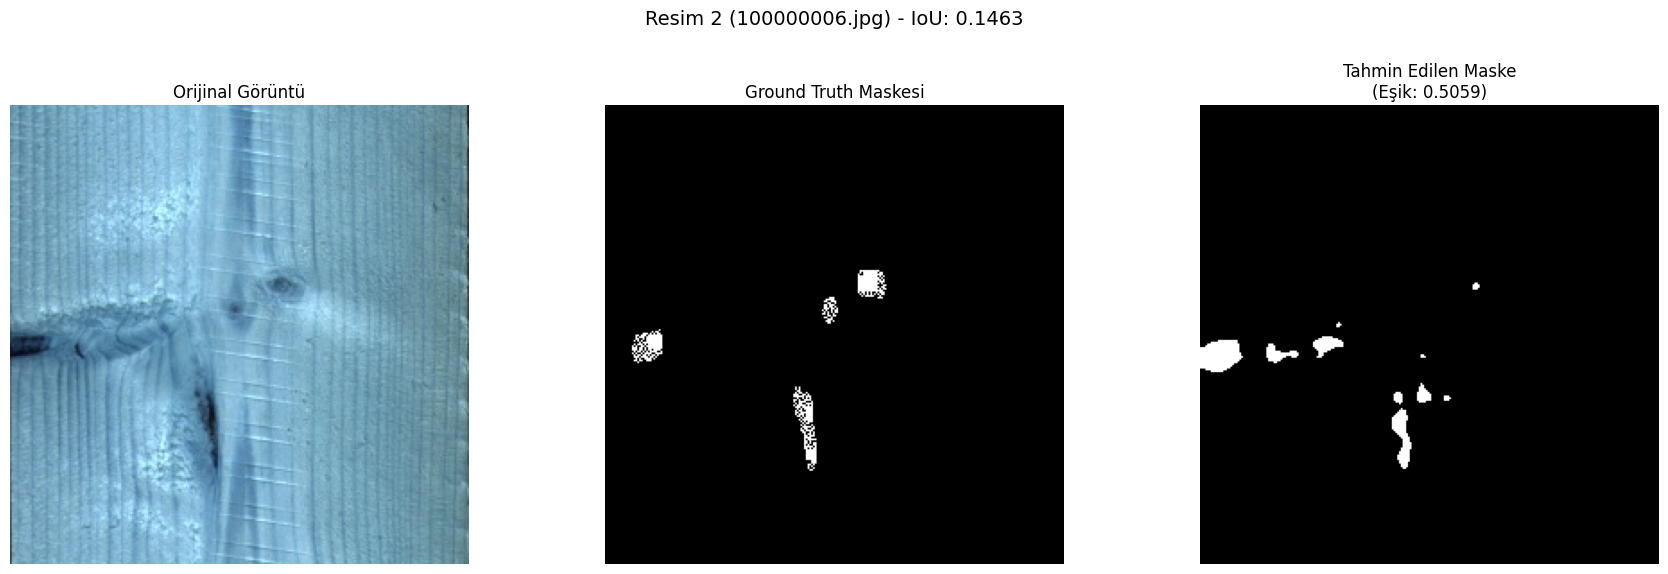

Resim 3 (100000007.jpg): IoU = 0.3582


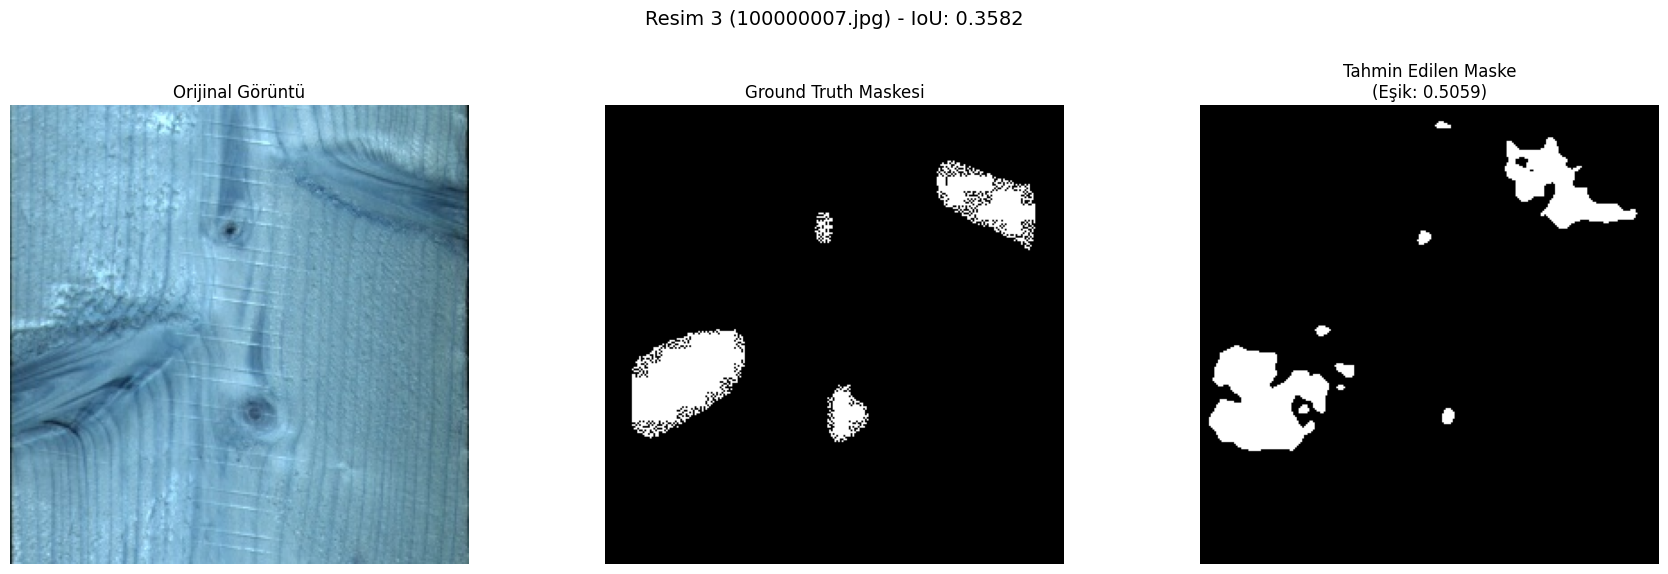

Resim 4 (100000008.jpg): IoU = 0.1013


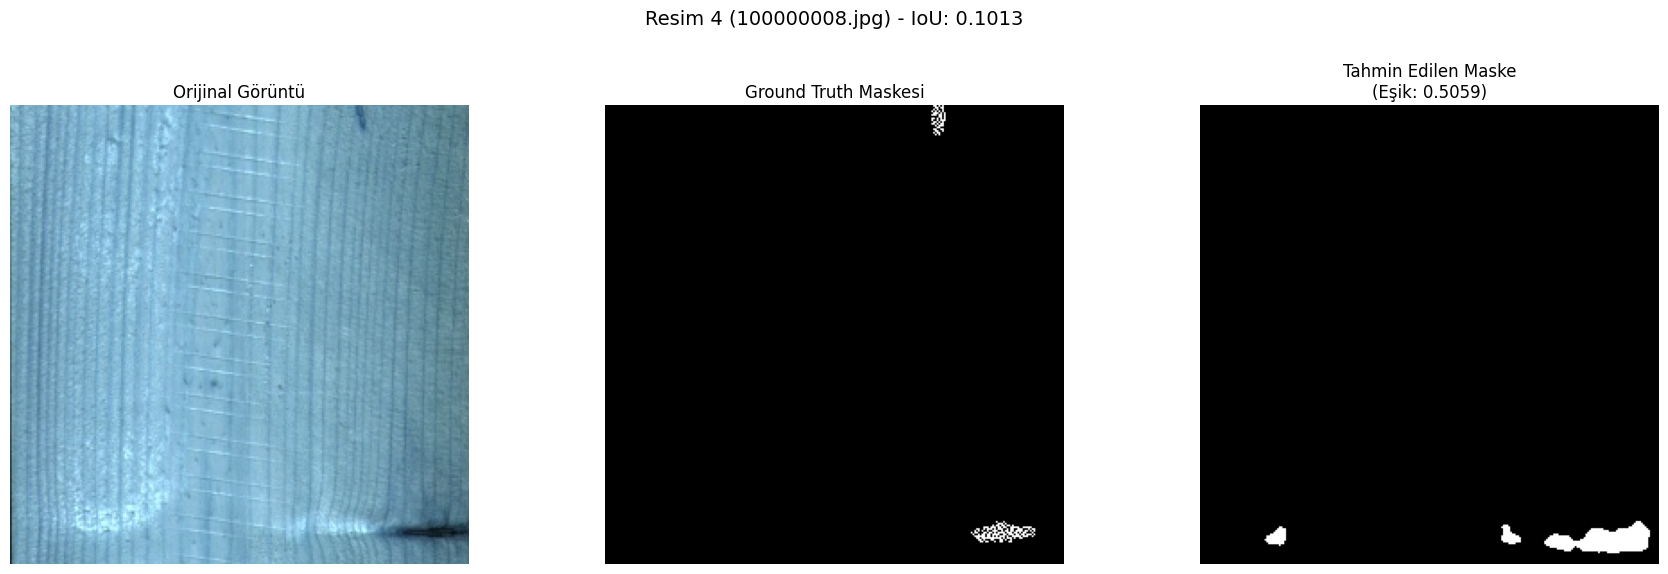

Resim 5 (100000016.jpg): IoU = 0.2947


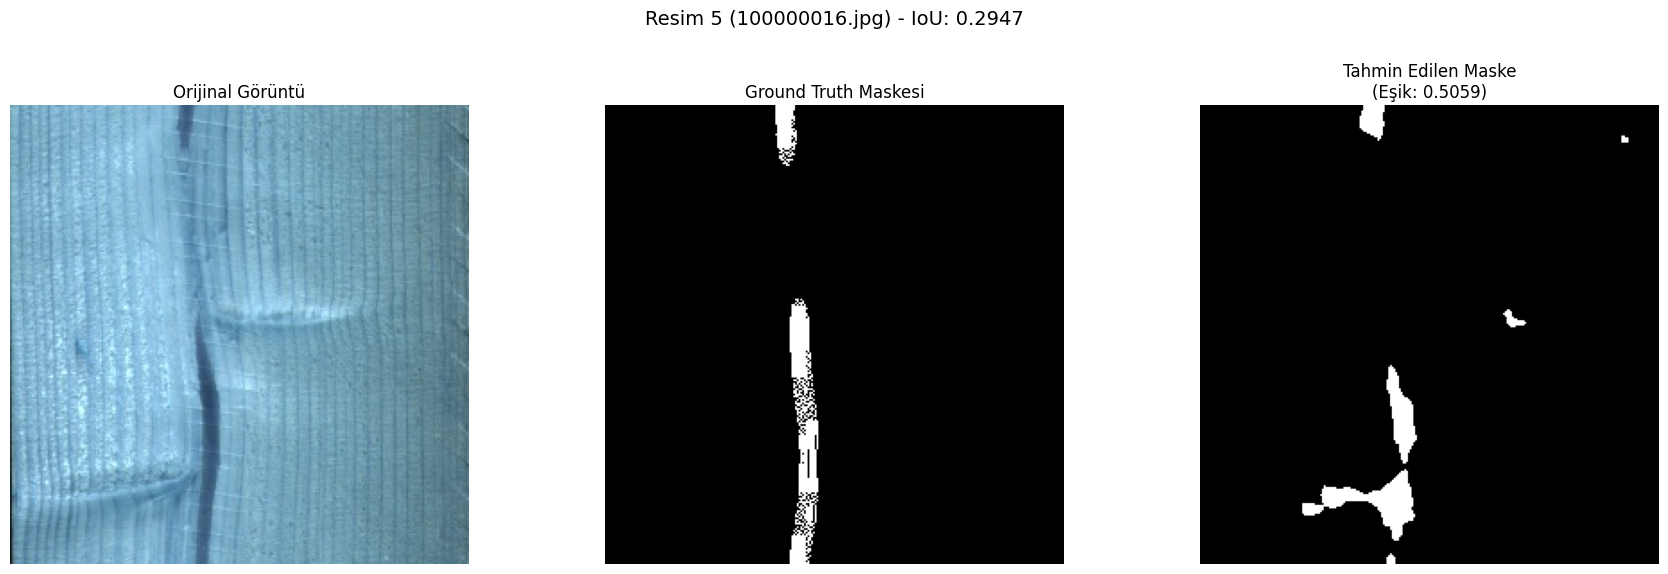


Gösterilen 5 Maskeli Resim İçin Ortalama IoU: 0.1801


In [46]:
from anomalib.metrics.threshold import F1AdaptiveThreshold

f1_threshold_finder = F1AdaptiveThreshold(fields=["anomaly_map", "gt_mask"])

all_predictions_batches = engine.predict(model, datamodule=datamodule)


processed_batches_for_threshold = 0
for batch_item in all_predictions_batches:
    if batch_item.gt_mask is not None and hasattr(batch_item, 'anomaly_map') and batch_item.anomaly_map is not None:
         try:
            f1_threshold_finder.update(batch_item)
            processed_batches_for_threshold += 1
         except Exception as e:
             print(f"Uyarı: Bir batch işlenirken hata oluştu (Eşik update): {e}. Batch atlanıyor.")


try:
    computed_f1_threshold = f1_threshold_finder.compute()
    print(f"\nF1AdaptiveThreshold ile Hesaplanan Optimal Piksel Eşiği: {computed_f1_threshold.item():.4f}")
except Exception as e:
     print(f"\n!!! Hata: F1AdaptiveThreshold compute() metodunda hata oluştu: {e}")
     print("!!! Geçici olarak varsayılan 0.5 eşiği kullanılacaktır.")
     computed_f1_threshold = torch.tensor(0.5)

optimal_threshold = computed_f1_threshold.item()


# İki ikili maske arasındaki IoU'yu hesaplayan fonksiyon
def calculate_iou(mask1, mask2):
    mask1 = np.asarray(mask1, dtype=bool)
    mask2 = np.asarray(mask2, dtype=bool)

    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()

    if union == 0:
        return 1.0 if intersection == 0 else 0.0

    return intersection / union

num_images_to_visualize = 5
processed_image_count = 0
subset_iou_scores = []

print(f"\nİlk {num_images_to_visualize} Resim İçin Maske Karşılaştırması ve IoU Dğerleri (Hesaplanan Eşik: {optimal_threshold:.4f} İle):")

# Saklanan prediction batch listesi üzerinde döngü yap
for batch_item in all_predictions_batches:
    batch_size = len(batch_item.image_path)

    for j in range(batch_size):
        if processed_image_count >= num_images_to_visualize:
            break

        current_image_path = batch_item.image_path[j]
        current_gt_mask_tensor = batch_item.gt_mask[j] if batch_item.gt_mask is not None and j < len(batch_item.gt_mask) else None
        current_anomaly_map_tensor = batch_item.anomaly_map[j] if batch_item.anomaly_map is not None and j < len(batch_item.anomaly_map) else None

        try:
            anomaly_map_np = current_anomaly_map_tensor.squeeze().cpu().numpy()
            ground_truth_mask_np = current_gt_mask_tensor.squeeze().cpu().numpy() if current_gt_mask_tensor is not None else np.zeros_like(anomaly_map_np)
        except Exception as e:
            print(f"Hata: Resim {processed_image_count + 1} ({os.path.basename(current_image_path)}) tensorları numpy'ye çevirirken hata oluştu: {e}. Atlanıyor.")
            continue

        ground_truth_mask_binary = ground_truth_mask_np > 0

        smoothed_map_np = cv2.GaussianBlur(anomaly_map_np, (5, 5), 0)

        predicted_mask_binary = smoothed_map_np > optimal_threshold

        iou = -1
        if current_gt_mask_tensor is not None:
             try:
                iou = calculate_iou(ground_truth_mask_binary, predicted_mask_binary)
                subset_iou_scores.append(iou)
                print(f"Resim {processed_image_count + 1} ({os.path.basename(current_image_path)}): IoU = {iou:.4f}")
             except Exception as e:
                print(f"Hata: Resim {processed_image_count + 1} ({os.path.basename(current_image_path)}) için IoU hesaplarken hata oluştu: {e}.")
                continue

        else:
             print(f"Resim {processed_image_count + 1} ({os.path.basename(current_image_path)}): GT Maske Yok. IoU Hesaplanmadı.")


        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        try:
            original_image_pil = Image.open(current_image_path).convert("RGB")
            axes[0].imshow(original_image_pil)
            axes[0].set_title("Orijinal Görüntü")
            axes[0].axis('off')
        except Exception as e:
            print(f"Hata: Resim {processed_image_count + 1} ({current_image_path}) yüklenirken hata oluştu: {e}. Gösterilemiyor.")
            axes[0].set_title("Görüntü Yükleme Hatası")
            axes[0].axis('off')

        axes[1].imshow(ground_truth_mask_binary, cmap='gray')
        axes[1].set_title("Ground Truth Maskesi" if current_gt_mask_tensor is not None else "GT Maske Yok")
        axes[1].axis('off')

        axes[2].imshow(predicted_mask_binary, cmap='gray')
        axes[2].set_title(f"Tahmin Edilen Maske\n(Eşik: {optimal_threshold:.4f})")
        axes[2].axis('off')

        main_title = f"Resim {processed_image_count + 1} ({os.path.basename(current_image_path)})"
        if iou != -1:
            main_title += f" - IoU: {iou:.4f}"
        plt.suptitle(main_title, fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()

        processed_image_count += 1

    if processed_image_count >= num_images_to_visualize:
        break

if subset_iou_scores:
      average_iou_subset = sum(subset_iou_scores) / len(subset_iou_scores)
      print(f"\nGösterilen {len(subset_iou_scores)} Maskeli Resim İçin Ortalama IoU: {average_iou_subset:.4f}")
else:
      print("\nHiçbir maskeli resim başarıyla işlenemedi veya gösterilecek yeterli maskeli resim bulunamadı.")

##2.2 EfficientAD

In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
!git clone https://github.com/nelson1425/EfficientAD

Cloning into 'EfficientAD'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 37 (delta 12), reused 9 (delta 9), pack-reused 17 (from 1)
Receiving objects: 100% (37/37), 37.98 MiB | 16.33 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [ ]:
%cd /content/drive/MyDrive/EfficientAD

/content/drive/MyDrive/EfficientAD


In [ ]:
#loss_st = loss_hard + loss_penalty
!python /content/drive/MyDrive/EfficientAD/efficientad.py \
  --mvtec_ad_path '/content/drive/MyDrive/processed_dataset' \
  --weights '/content/drive/MyDrive/EfficientAD/models/teacher_small.pth' \
  --output_dir '/content/drive/MyDrive/outputs/efficient' \
  --subdataset wood \
  --model_size small \
  --imagenet_train_path none \
  --train_steps 20000

Computing mean of features: 100% 63/63 [00:00<00:00, 63.48it/s]
Computing std of features: 100% 63/63 [00:00<00:00, 191.68it/s]
Current loss: 6.3046:  50% 10000/20000 [02:48<02:18, 72.31it/s]
Intermediate map normalization: 100% 7/7 [00:00<00:00, 129.54it/s]

Intermediate inference:   0% 0/141 [00:00<?, ?it/s]
Intermediate inference:   5% 7/141 [00:00<00:01, 68.61it/s]
Intermediate inference:  16% 22/141 [00:00<00:01, 115.34it/s]
Intermediate inference:  27% 38/141 [00:00<00:00, 131.27it/s]
Intermediate inference:  38% 53/141 [00:00<00:00, 138.24it/s]
Intermediate inference:  48% 68/141 [00:00<00:00, 139.64it/s]
Intermediate inference:  58% 82/141 [00:00<00:00, 136.59it/s]
Intermediate inference:  70% 99/141 [00:00<00:00, 144.71it/s]
Intermediate inference:  82% 115/141 [00:00<00:00, 148.53it/s]
Intermediate inference: 100% 141/141 [00:01<00:00, 137.71it/s]

\ Anomaly Detection Sonucları
AUC Score          : 0.8340
F1 Score           : 0.7917
Precision          : 0.7808
Recall         

In [ ]:
#loss_st = loss_hard + loss_penalty
!python /content/drive/MyDrive/EfficientAD/efficientad.py \
  --mvtec_ad_path '/content/drive/MyDrive/processed_dataset' \
  --weights '/content/drive/MyDrive/EfficientAD/models/teacher_medium.pth' \
  --output_dir '/content/drive/MyDrive/outputs/efficient' \
  --subdataset wood \
  --model_size medium \
  --imagenet_train_path none \
  --train_steps 20000

Computing mean of features: 100% 63/63 [00:00<00:00, 113.66it/s]
Computing std of features: 100% 63/63 [00:00<00:00, 202.48it/s]
Current loss: 5.6926:  50% 9998/20000 [04:33<04:03, 41.02it/s]
Intermediate map normalization: 100% 7/7 [00:00<00:00, 120.13it/s]

Intermediate inference:   0% 0/141 [00:00<?, ?it/s]
Intermediate inference:   8% 11/141 [00:00<00:01, 107.53it/s]
Intermediate inference:  17% 24/141 [00:00<00:01, 116.82it/s]
Intermediate inference:  26% 37/141 [00:00<00:00, 120.59it/s]
Intermediate inference:  35% 50/141 [00:00<00:00, 123.25it/s]
Intermediate inference:  45% 63/141 [00:00<00:00, 122.88it/s]
Intermediate inference:  54% 76/141 [00:00<00:00, 117.87it/s]
Intermediate inference:  63% 89/141 [00:00<00:00, 119.41it/s]
Intermediate inference:  72% 102/141 [00:00<00:00, 120.47it/s]
Intermediate inference:  82% 115/141 [00:00<00:00, 121.50it/s]
Intermediate inference:  91% 128/141 [00:01<00:00, 123.33it/s]
Intermediate inference: 100% 141/141 [00:01<00:00, 121.12it/s]

\

In [ ]:
#loss_st = loss_hard + 0.5 * loss_penalty
!python /content/drive/MyDrive/EfficientAD/efficientad.py \
  --mvtec_ad_path '/content/drive/MyDrive/processed_dataset' \
  --weights '/content/drive/MyDrive/EfficientAD/models/teacher_medium.pth' \
  --output_dir '/content/drive/MyDrive/outputs/efficient' \
  --subdataset wood \
  --model_size medium \
  --imagenet_train_path none \
  --train_steps 20000

Computing mean of features: 100% 63/63 [00:00<00:00, 112.06it/s]
Computing std of features: 100% 63/63 [00:00<00:00, 212.67it/s]
Current loss: 5.4918:  50% 9996/20000 [04:22<04:00, 41.54it/s]
Intermediate map normalization: 100% 7/7 [00:00<00:00, 127.05it/s]

Intermediate inference:   0% 0/141 [00:00<?, ?it/s]
Intermediate inference:   9% 12/141 [00:00<00:01, 116.32it/s]
Intermediate inference:  18% 25/141 [00:00<00:00, 119.02it/s]
Intermediate inference:  27% 38/141 [00:00<00:00, 122.65it/s]
Intermediate inference:  36% 51/141 [00:00<00:00, 123.89it/s]
Intermediate inference:  45% 64/141 [00:00<00:00, 118.33it/s]
Intermediate inference:  55% 77/141 [00:00<00:00, 120.20it/s]
Intermediate inference:  64% 90/141 [00:00<00:00, 122.25it/s]
Intermediate inference:  73% 103/141 [00:00<00:00, 124.08it/s]
Intermediate inference:  82% 116/141 [00:00<00:00, 124.58it/s]
Intermediate inference: 100% 141/141 [00:01<00:00, 122.06it/s]

\ Anomaly Detection Sonucları
AUC Score          : 0.8744
F1 Sco

In [ ]:
#loss_st = loss_hard + loss_penalty
!python /content/drive/MyDrive/EfficientAD/efficientad.py \
  --mvtec_ad_path '/content/drive/MyDrive/processed_dataset' \
  --weights '/content/drive/MyDrive/EfficientAD/models/teacher_medium.pth' \
  --output_dir '/content/drive/MyDrive/outputs/efficient' \
  --subdataset wood \
  --model_size medium \
  --imagenet_train_path none \
  --train_steps 30000

Computing mean of features: 100% 63/63 [00:00<00:00, 109.21it/s]
Computing std of features: 100% 63/63 [00:00<00:00, 189.02it/s]
Current loss: 4.1479:  33% 9996/30000 [04:34<08:19, 40.01it/s]
Intermediate map normalization: 100% 7/7 [00:00<00:00, 94.82it/s]

Intermediate inference:   0% 0/141 [00:00<?, ?it/s]
Intermediate inference:   8% 11/141 [00:00<00:01, 109.02it/s]
Intermediate inference:  16% 22/141 [00:00<00:02, 51.25it/s] 
Intermediate inference:  23% 33/141 [00:00<00:01, 67.46it/s]
Intermediate inference:  32% 45/141 [00:00<00:01, 80.70it/s]
Intermediate inference:  40% 56/141 [00:00<00:00, 88.34it/s]
Intermediate inference:  48% 67/141 [00:00<00:00, 92.30it/s]
Intermediate inference:  55% 78/141 [00:00<00:00, 96.11it/s]
Intermediate inference:  63% 89/141 [00:01<00:00, 96.96it/s]
Intermediate inference:  72% 101/141 [00:01<00:00, 101.86it/s]
Intermediate inference:  80% 113/141 [00:01<00:00, 104.45it/s]
Intermediate inference:  88% 124/141 [00:01<00:00, 105.62it/s]
Intermedia

In [ ]:
!python /content/drive/MyDrive/EfficientAD/efficientad.py \
  --mvtec_ad_path '/content/drive/MyDrive/processed_dataset' \
  --weights '/content/drive/MyDrive/EfficientAD/models/teacher_medium.pth' \
  --output_dir '/content/drive/MyDrive/outputs/efficient' \
  --subdataset wood \
  --model_size medium \
  --imagenet_train_path none \
  --train_steps 30000

Computing mean of features: 100% 63/63 [00:00<00:00, 109.74it/s]
Computing std of features: 100% 63/63 [00:00<00:00, 215.82it/s]
Current loss: 5.6638:  33% 9998/30000 [04:22<07:58, 41.83it/s]
Intermediate map normalization: 100% 7/7 [00:00<00:00, 113.74it/s]

Intermediate inference:   0% 0/141 [00:00<?, ?it/s]
Intermediate inference:   2% 3/141 [00:00<00:09, 14.31it/s]
Intermediate inference:  11% 15/141 [00:00<00:02, 57.11it/s]
Intermediate inference:  20% 28/141 [00:00<00:01, 82.36it/s]
Intermediate inference:  29% 41/141 [00:00<00:01, 97.53it/s]
Intermediate inference:  38% 54/141 [00:00<00:00, 106.69it/s]
Intermediate inference:  48% 67/141 [00:00<00:00, 113.37it/s]
Intermediate inference:  56% 79/141 [00:00<00:00, 114.18it/s]
Intermediate inference:  65% 92/141 [00:00<00:00, 118.54it/s]
Intermediate inference:  74% 105/141 [00:01<00:00, 121.38it/s]
Intermediate inference:  84% 119/141 [00:01<00:00, 124.17it/s]
Intermediate inference: 100% 141/141 [00:01<00:00, 106.80it/s]

\ Anoma

In [ ]:
import os
import numpy as np
import tifffile
import cv2
from glob import glob
from sklearn.metrics import jaccard_score

pred_mask_dir = '/content/drive/MyDrive/outputs/efficient/anomaly_maps/mvtec_ad/wood/test/defect'
gt_mask_dir = '/content/drive/MyDrive/processed_dataset/wood/ground_truth/defect/'

thresholds = np.linspace(0.01, 0.5, 50)
best_iou = 0
best_thresh = 0

for thresh in thresholds:
    ious = []
    for pred_path in sorted(glob(os.path.join(pred_mask_dir, '*.tiff'))):
        file_id = os.path.splitext(os.path.basename(pred_path))[0]
        gt_path = os.path.join(gt_mask_dir, f"{file_id}_mask.jpg")
        gt_filename = f"{file_id}_mask.jpg"

        if not os.path.exists(gt_path):
            continue

        pred_mask = tifffile.imread(pred_path)
        gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

        pred_bin = (pred_mask > thresh).astype(np.uint8)
        gt_bin = (gt_mask > 0).astype(np.uint8)

        iou = jaccard_score(gt_bin.flatten(), pred_bin.flatten())
        ious.append(iou)

    mean_iou = np.mean(ious)
    if mean_iou > best_iou:
        best_iou = mean_iou
        best_thresh = thresh

print(f"En iyi threshold (IoU'ya göre): {best_thresh:.4f} | Ortalama IoU: {best_iou:.4f}")


En iyi threshold (IoU'ya göre): 0.0800 | Ortalama IoU: 0.2597


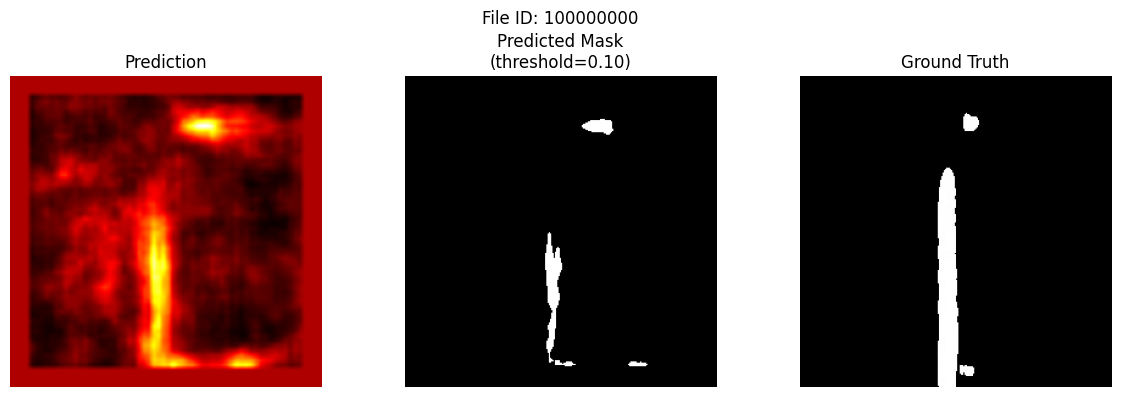

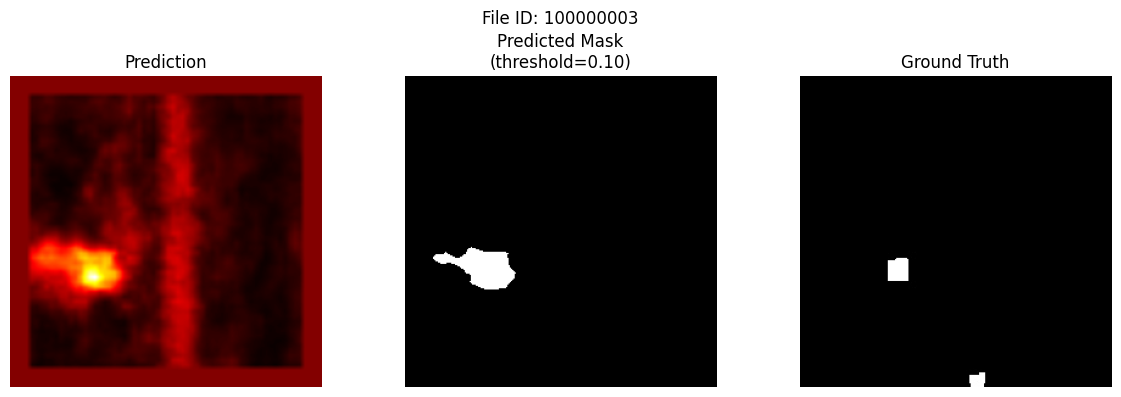

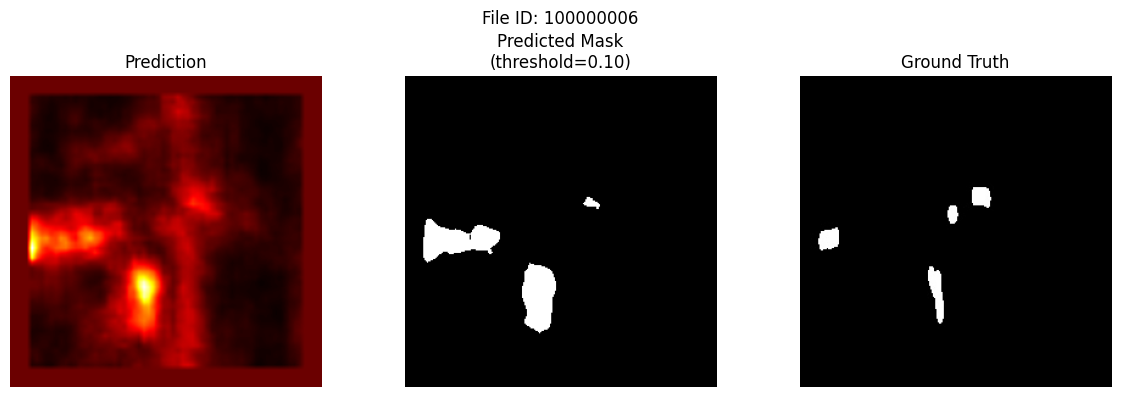

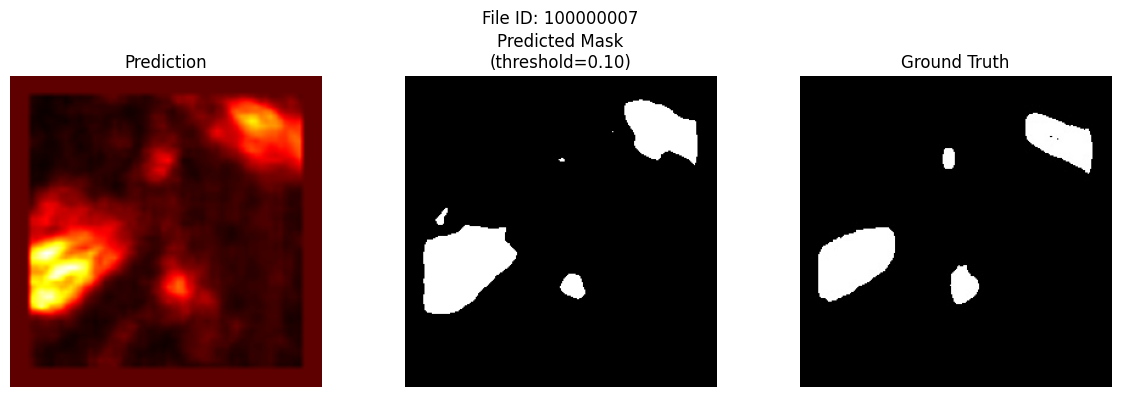

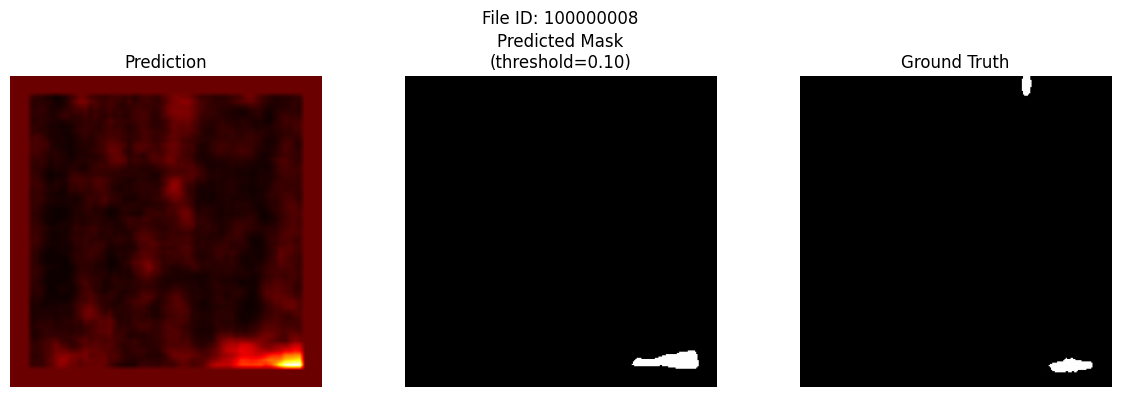

In [ ]:
import os
import cv2
import tifffile
import matplotlib.pyplot as plt
from glob import glob

# Dosya yolları
pred_paths = sorted(glob(os.path.join(pred_dir, "*.tiff")))

threshold = 0.09  # En iyi bulunan threshold

for i in range(5):
    pred_path = pred_paths[i]
    file_id = os.path.splitext(os.path.basename(pred_path))[0]
    gt_path = os.path.join(gt_mask_dir, f"{file_id}_mask.jpg")

    if not os.path.exists(gt_path):
        print(f"❌ Ground truth eksik: {file_id}_mask.jpg")
        continue

    # Maske yükle
    pred_mask = tifffile.imread(pred_path)
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

    pred_mask = cv2.resize(pred_mask, (256, 256))
    gt_mask = cv2.resize(gt_mask, (256, 256))

    # Binary maskeye çevir
    pred_bin = (pred_mask > threshold).astype(np.uint8)

    # Görselleştir
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Prediction")
    plt.imshow(pred_mask, cmap='hot')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(f"Predicted Mask\n(threshold={threshold:.2f})")
    plt.imshow(pred_bin, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Ground Truth")
    plt.imshow(gt_mask, cmap='gray')
    plt.axis('off')

    plt.suptitle(f"File ID: {file_id}")
    plt.tight_layout()
    plt.show()
